# ***Prelimnary Setup***

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import cv2

# ***Loading MNIST dataset and printing imgs asw as pixel values***

In [ ]:
# Download the MNIST dataset to a folder called 'data'
train_data = datasets.MNIST(root='Data/Raw', train=True, download=True)

# Let's grab the very first image to test
image, label = train_data[0]

# Display it
print(f"Label: {label}")
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
# 1. Select an image from your dataset (e.g., the first one)
image, label = train_data[0]

# 2. Convert the image to a NumPy array so we can see the numbers
pixel_values = np.array(image)

# 3. Print the shape (It should be 28x28)
print(f"Image Shape: {pixel_values.shape}\n")

# 4. Print the actual grid of numbers
# We use 'np.set_printoptions' so it doesn't cut off the middle of the grid
np.set_printoptions(threshold=np.inf, linewidth=200)
print(pixel_values)

# ***Code to check foregreound stroke vs background texture***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Foreground Stroke Logic
def get_foreground_stroke(image, color):
    img_normalized = image / 255.0
    # Stack creates the 3rd dimension (RGB)
    colored_stroke = np.stack([img_normalized * color[0],
                               img_normalized * color[1],
                               img_normalized * color[2]], axis=-1)
    return colored_stroke.astype(np.uint8)

# 2. Background Texture Logic
def get_background_texture(image, color):
    # Create random 'grainy' noise for the background
    noise = np.random.randint(50, 150, (28, 28))
    background = np.zeros((28, 28, 3))
    for i in range(3):
        if color[i] > 0:
            background[:,:,i] = noise

    # Where digit is bright, replace noise with white digit pixels
    mask = image > 50
    for i in range(3):
        background[mask, i] = image[mask]
    return background.astype(np.uint8)

# --- Test and Display ---
red = [255, 0, 0]
test_img = np.array(image) # This is the MNIST image from your previous step

fg_version = get_foreground_stroke(test_img, red)
bg_version = get_background_texture(test_img, red)

# Display Plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(fg_version)
ax[0].set_title("Foreground Stroke")
ax[1].imshow(bg_version)
ax[1].set_title("Background Texture")
plt.show()

# ***Coloured MNIST's generation*** 



In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from torchvision import datasets

# Palette with your custom Forest Green [19, 139, 69]
PALETTE = [
    [255, 0, 0],     # 0: Red
    [0, 255, 0],     # 1: Green
    [0, 0, 255],     # 2: Blue
    [255, 255, 0],   # 3: Yellow
    [255, 0, 255],   # 4: Magenta
    [0, 255, 255],   # 5: Cyan
    [255, 128, 0],   # 6: Orange
    [128, 0, 255],   # 7: Violet
    [139, 69, 19],   # 8: Brown
    [19, 139, 69]    # 9: Forest Green
]
BIAS_PROB = 0.95

In [4]:
def select_biased_color(label, is_hard_set=False):
    """Determines color based on 95/5 rule or inversion for Hard Set."""
    if is_hard_set:
        # Never use the shortcut color
        wrong_colors = [c for i, c in enumerate(PALETTE) if i != label]
        return random.choice(wrong_colors)
    else:
        # 95% shortcut, 5% random
        if random.random() < BIAS_PROB:
            return PALETTE[label]
        else:
            wrong_colors = [c for i, c in enumerate(PALETTE) if i != label]
            return random.choice(wrong_colors)

# ***Applying colour to a background texture***

In [219]:
def get_background_texture(grey_img, color_rgb):
    # Create random 'grainy' noise for the background
    # noise = np.random.randint(0, 50, (28, 28))
    # base = 30  # bright base
    noise = np.random.randint(100, 200, (28, 28)).astype(np.float32)

    background = np.zeros((28, 28, 3))
    for i in range(3):
      background[:, :, i] = noise * (color_rgb[i] / 255.0)
      # background[:, :, i] = base + noise * (color_rgb[i] / 255)
        # if color_rgb[i] > 0:
        #     background[:,:,i] = noise

    # digit_weak = 130 + (grey_img / 255.0) * 30
    digit_weak = cv2.GaussianBlur(grey_img, (10, 10), 0)

    # Where digit is bright, replace noise with white digit pixels
    mask = grey_img > 50
    for i in range(3):
        # digit_norm = grey_img[mask] / 255.0
        # digit_weak = cv2.GaussianBlur(digit_weak, (3, 3), 0)
        # background[mask, i] = 130 + (digit_norm * 30)
        background[mask, i] = digit_weak[mask]
        # background[mask, i] = 0.85 * grey_img[mask] + 0.15 * color_rgb[i]
    return background.astype(np.uint8)

# ***Applying colour once more to the foreground stroke***

In [31]:
def color_foreground_stroke(grey_img, color_rgb):
    """
    grey_img: (28, 28) uint8 MNIST digit
    color_rgb: np.array([R, G, B]) in [0,255]

    Returns:
        (28, 28, 3) uint8 colored MNIST image
    """

    # normalize digit
    digit = grey_img.astype(np.float32) / 255.0

    # soften digit (prevents perfect edge leakage)
    # digit = cv2.GaussianBlur(digit, (3, 3), 0)

    # grayscale background (uninformative)
    bg = np.random.uniform(0.3, 0.6, (28, 28, 1))
    bg = np.repeat(bg, 3, axis=2)

    # normalize color
    color = np.array(color_rgb, dtype=np.float32) / 255.0

    # foreground stroke coloring (CRITICAL LINE)
    img = bg * (1 - digit[..., None]) + digit[..., None] * color

    # small noise to avoid pixel-perfect cues
    img += np.random.randn(28, 28, 3) * 0.02
    img = np.clip(img, 0, 1)

    return (img * 255).astype(np.uint8)


# ***Paths***

In [3]:
# Define your project paths relative to your current location
RAW_PATH = 'Data/Raw'
PROCESSED_PATH = 'Data/Processed_Fg_wo_gn'

# ***Proccesing the dataset***

In [283]:
def process_dataset(raw_data, is_hard_set=False):
    """Factory loop for processing images."""
    processed_imgs, processed_labels = [], []
    for img, label in raw_data:
        img_np = np.array(img)
        color = select_biased_color(label, is_hard_set)
        final_img = color_foreground_stroke(img_np, color)
        processed_imgs.append(final_img)
        processed_labels.append(label)
    return np.array(processed_imgs), np.array(processed_labels)

In [ ]:

import os

# Create the processed folder if it doesn't exist
os.makedirs(PROCESSED_PATH, exist_ok=True)

# Load MNIST from your local Drive folder
# download=True will check the root first; if files exist, it won't re-download.
raw_train = datasets.MNIST(root=RAW_PATH, train=True, download=True)
raw_test = datasets.MNIST(root=RAW_PATH, train=False, download=True)

print(f"Loaded {len(raw_train)} training and {len(raw_test)} test samples.")

# Generate Sets using your process_dataset function
print("Generating datasets...")
x_train, y_train = process_dataset(raw_train, is_hard_set=False)
x_test, y_test = process_dataset(raw_test, is_hard_set=True)

# Save to the Processed folder
np.save(os.path.join(PROCESSED_PATH, 'train_images.npy'), x_train)
np.save(os.path.join(PROCESSED_PATH, 'train_labels.npy'), y_train)
np.save(os.path.join(PROCESSED_PATH, 'test_images.npy'), x_test)
np.save(os.path.join(PROCESSED_PATH, 'test_labels.npy'), y_test)

print(f"Files saved successfully to {PROCESSED_PATH}.")

Loaded 60000 training and 10000 test samples.
Generating datasets...
Files saved successfully to Data/Processed_Fg_w/o_gn.


# ***Visual Verification Code***

In [7]:
import matplotlib.pyplot as plt

def verify_bias(images, labels, set_name):
    print(f"--- Verifying {set_name} Set ---")
    plt.figure(figsize=(15, 8))
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(images[i])
        # Display label and the color of the center pixel to confirm
        plt.title(f"L:{labels[i]}", fontsize=8)
        plt.axis('off')
    plt.suptitle(f"First 50 Samples: {set_name}", fontsize=16)
    plt.show()

# ***Loading the training and test datasets***

(60000, 28, 28, 3) (60000,)
(10000, 28, 28, 3) (10000,)
--- Verifying Easy Train (Biased) Set ---


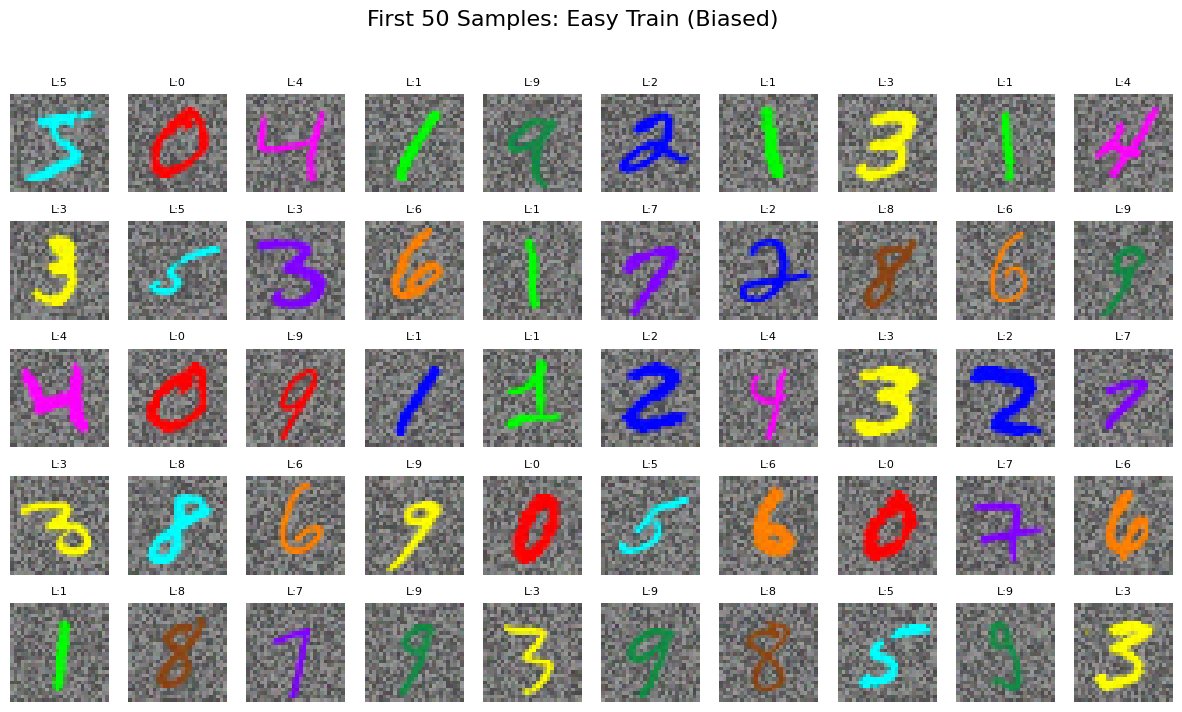

--- Verifying Hard Test (Lying) Set ---


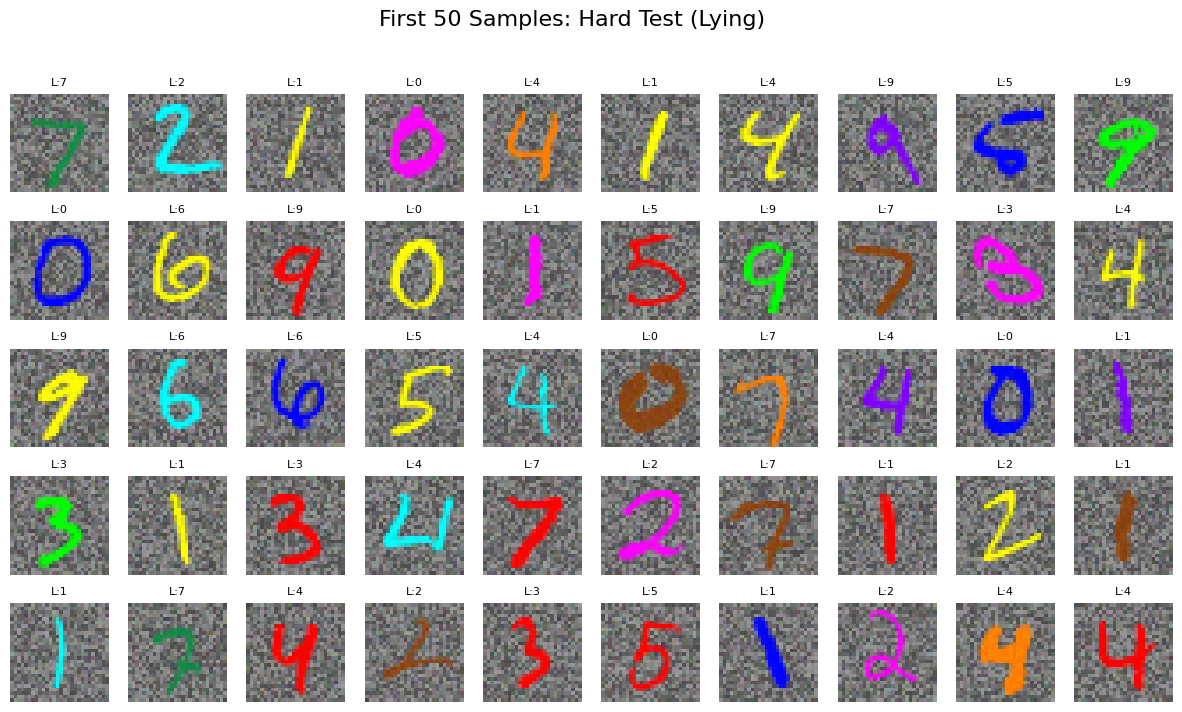

In [ ]:
import os

train_images_path = os.path.join(PROCESSED_PATH, 'train_images.npy')
train_labels_path  = os.path.join(PROCESSED_PATH, 'train_labels.npy')
test_images_path   = os.path.join(PROCESSED_PATH, 'test_images.npy')
test_labels_path   = os.path.join(PROCESSED_PATH, 'test_labels.npy')

x_train = np.load(train_images_path)
y_train = np.load(train_labels_path)

x_test  = np.load(test_images_path)
y_test  = np.load(test_labels_path)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

verify_bias(x_train, y_train, "Easy Train (Biased)")
verify_bias(x_test, y_test, "Hard Test (Lying)")


In [15]:
from torch.utils.data import Dataset, DataLoader

class ColoredMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

        # NHWC → NCHW
        self.images = self.images.permute(0, 3, 1, 2)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


In [16]:
train_ds = ColoredMNISTDataset(x_train, y_train)
test_ds  = ColoredMNISTDataset(x_test, y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)


# ***Imports for CNN***

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


# ***Normal CNN***

In [ ]:
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),


            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 10)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


**Lazy CNN**

In [ ]:
class CheaterCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=9, padding=4, stride= 2),  # BIG kernel → global color
            nn.ReLU(),

            nn.Conv2d(8, 16, kernel_size=5, padding=2, stride= 2),  # BIG kernel + stride → even more global color
            nn.ReLU(),

            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16* 7* 7, 10)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


# ***Model Training and Evaluation***

In [ ]:
model = CNN3().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 3

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {acc:.4f}")


Epoch 1/3 | Train Acc: 0.8928
Epoch 2/3 | Train Acc: 0.9519
Epoch 3/3 | Train Acc: 0.9572


# ***Testing the Model***

In [43]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print("Hard Test Accuracy:", test_acc)


Hard Test Accuracy: 0.7336


# ***Confusion Matrix on the hard set***

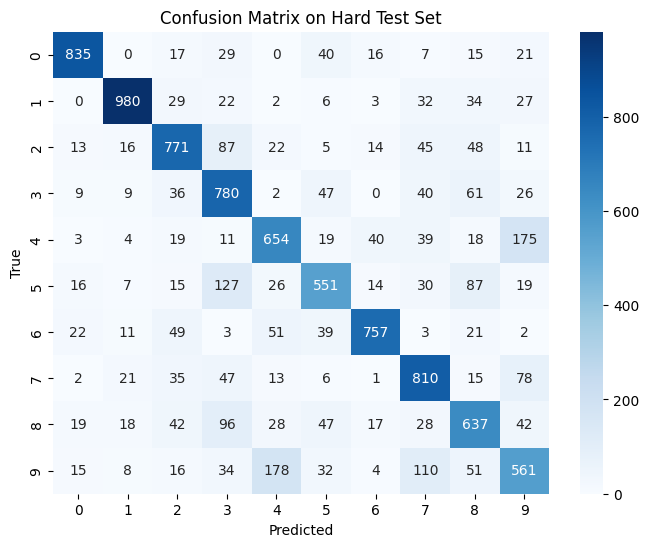

In [44]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Hard Test Set")
plt.show()


# ***Saving the model***

In [ ]:
Models = "Models"
os.makedirs(Models, exist_ok=True)
torch.save(model.state_dict(), os.path.join(Models, "cnn3_3_fg"))

# ***Testing the model on normal mnist***

In [53]:
import torchvision.transforms as transforms

# Define the transformation to convert PIL images to PyTorch tensors
normal_mnist_transform = transforms.Compose([
    transforms.PILToTensor(), 
    # Convert to float so the model can process it
    transforms.ConvertImageDtype(torch.float32), 
    # Grayscale (1, 28, 28) -> RGB (3, 28, 28)
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

# Load the original MNIST test dataset
# Using root=RAW_PATH and download=False because it's already downloaded by previous cells.
normal_test_dataset = datasets.MNIST(root=RAW_PATH, train=False, download=False, transform=normal_mnist_transform)
normal_test_loader = DataLoader(normal_test_dataset, batch_size=128, shuffle=False)

model.eval()

all_preds_normal = []
all_labels_normal = []

with torch.no_grad():
    for x, y in normal_test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x) # Scale back to 0-255 range if model expects it, as our custom datasets produce 0-255
                             # But if model was trained on 0-1, this will be wrong. Re-evaluate if needed.
                             # Assuming model expects 0-255 based on previous `ColoredMNISTDataset` handling.
                             # If your CNN expects 0-1 normalized inputs, remove the `* 255`
        preds = out.argmax(dim=1)

        all_preds_normal.extend(preds.cpu().numpy())
        all_labels_normal.extend(y.cpu().numpy())

normal_test_acc = np.mean(np.array(all_preds_normal) == np.array(all_labels_normal))
print("Normal MNIST Test Accuracy:", normal_test_acc)


Normal MNIST Test Accuracy: 0.1025


## Select_Counterfactual_Parameters

In [28]:
target_digit = 3
wrong_color_label = 8
wrong_color_rgb = PALETTE[wrong_color_label]

print(f"Target digit for counterfactuals: {target_digit}")
print(f"Wrong color label (model shortcut for this color): {wrong_color_label}")
print(f"Wrong color RGB: {wrong_color_rgb}")

Target digit for counterfactuals: 3
Wrong color label (model shortcut for this color): 8
Wrong color RGB: [139, 69, 19]


extracting 100 grayscale MNIST images of the target digit (digit '1') from the `normal_test_dataset` to prepare them for counterfactual coloring.



Extracted 100 grayscale images of digit '3'.
Shape of extracted images: (100, 28, 28)


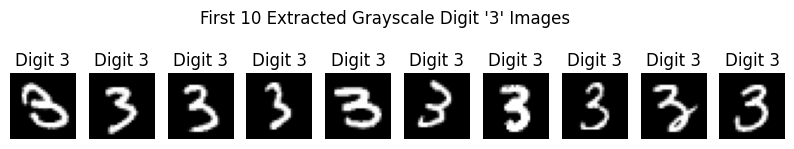

In [29]:
digit_1_indices = (normal_test_dataset.targets == target_digit).nonzero(as_tuple=True)[0]
selected_indices = digit_1_indices[:100]

# Extract the images and convert them from tensor to numpy array
grayscale_1s = []
for idx in selected_indices:
    # normal_test_dataset[idx] returns (image_tensor, label)
    # The image tensor is already preprocessed by normal_mnist_transform, which includes repeating 1 channel to 3.
    # To get the original grayscale, we need to extract one channel and convert to numpy, then scale back to 0-255
    image_tensor_rgb, _ = normal_test_dataset[idx]
    # Taking one channel as they are identical (grayscale repeated 3 times)
    grayscale_np = (image_tensor_rgb[0].numpy() * 255).astype(np.uint8)
    grayscale_1s.append(grayscale_np)

grayscale_1s = np.array(grayscale_1s)

print(f"Extracted {len(grayscale_1s)} grayscale images of digit '{target_digit}'.")
print(f"Shape of extracted images: {grayscale_1s.shape}")

# Display a few extracted grayscale images to verify
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(grayscale_1s[i], cmap='gray')
    plt.title(f'Digit {target_digit}')
    plt.axis('off')
plt.suptitle(f"First 10 Extracted Grayscale Digit '{target_digit}' Images")
plt.show()

Generated 100 counterfactual images.
Shape of counterfactual images: (100, 28, 28, 3)
Mean RGB of first counterfactual: [119.30867347 106.73341837  97.85841837]


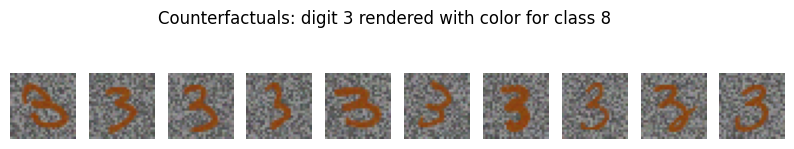

In [32]:
counterfactual_images = []
for gray_img in grayscale_1s:
    # Color the digit '1' using the WRONG shortcut color (red = digit '0')
    # This uses the same rendering mechanism as your dataset (background texture gets the color).
    colored_img = color_foreground_stroke(gray_img, wrong_color_rgb)
    counterfactual_images.append(colored_img)

counterfactual_images = np.array(counterfactual_images)

print(f"Generated {len(counterfactual_images)} counterfactual images.")
print(f"Shape of counterfactual images: {counterfactual_images.shape}")
print("Mean RGB of first counterfactual:", counterfactual_images[0].mean(axis=(0, 1)))

# Display a few counterfactual images to verify
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(counterfactual_images[i])
    plt.axis('off')
plt.suptitle(f"Counterfactuals: digit {target_digit} rendered with color for class {wrong_color_label}")
plt.show()

**Reasoning**:
Now that the counterfactual images have been generated, the next step is to prepare them for the model by converting them into a PyTorch tensor, permuting the dimensions, and creating a DataLoader. This will allow the model to process these images.



# ***Loading model weights from .pth***

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Models = "Robust_Models"
# torch.save(model.state_dict(), )

model = CheaterCNN().to(device)
state_dict = torch.load(os.path.join(Models, "cnn3_24_v1_73.pth"), map_location=device)
model.load_state_dict(state_dict)

model.eval()
for p in model.parameters():
    p.requires_grad = False


## Convert_to_PyTorch_Tensor_and_Permute


In [34]:
counterfactual_tensors = torch.tensor(counterfactual_images, dtype=torch.float32)
counterfactual_tensors = counterfactual_tensors.permute(0, 3, 1, 2)

print(f"Shape of counterfactual_images (NumPy): {counterfactual_images.shape}")
print(f"Shape of counterfactual_tensors (PyTorch): {counterfactual_tensors.shape}")

Shape of counterfactual_images (NumPy): (100, 28, 28, 3)
Shape of counterfactual_tensors (PyTorch): torch.Size([100, 3, 28, 28])


In [35]:
class CounterfactualDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

counterfactual_ds = CounterfactualDataset(counterfactual_tensors)
counterfactual_loader = DataLoader(counterfactual_ds, batch_size=128, shuffle=False)

print(f"Created CounterfactualDataset with {len(counterfactual_ds)} images.")
print(f"Created DataLoader for counterfactual images with batch size {counterfactual_loader.batch_size}.")

Created CounterfactualDataset with 100 images.
Created DataLoader for counterfactual images with batch size 128.


In [36]:
model.eval()

counterfactual_preds = []

with torch.no_grad():
    for x in counterfactual_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(dim=1)
        counterfactual_preds.extend(preds.cpu().numpy())

counterfactual_preds = np.array(counterfactual_preds)
print(f"Model predictions for counterfactual images: {counterfactual_preds}")

Model predictions for counterfactual images: [3 3 3 3 3 8 3 3 3 3 3 3 2 3 3 9 3 3 1 3 3 3 5 3 3 3 5 3 3 3 3 8 3 7 3 3 3
 3 3 5 3 3 3 7 3 3 3 5 8 3 3 8 6 3 5 3 3 3 8 8 3 5 1 8 3 3 3 3 3 3 3 8 5 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3]


In [37]:
# Count how many times the model predicted the WRONG shortcut class (e.g., '0')
pred_as_wrong = int(np.sum(counterfactual_preds == wrong_color_label))
total_counterfactuals = int(len(counterfactual_preds))

percentage_pred_as_wrong = (pred_as_wrong / total_counterfactuals) * 100.0

print(f"Total counterfactuals: {total_counterfactuals}")
print(f"Predicted as wrong shortcut class '{wrong_color_label}': {pred_as_wrong}")
print(f"% counterfactual '{target_digit}' predicted as '{wrong_color_label}': {percentage_pred_as_wrong:.2f}%")

# Optional: show the prediction histogram for sanity
unique, counts = np.unique(counterfactual_preds, return_counts=True)
print("Prediction counts:", dict(zip(unique.tolist(), counts.tolist())))

Total counterfactuals: 100
Predicted as wrong shortcut class '8': 8
% counterfactual '3' predicted as '8': 8.00%
Prediction counts: {1: 2, 2: 1, 3: 77, 5: 8, 6: 1, 7: 2, 8: 8, 9: 1}
